In [1]:
!pip install torch==2.0.1 torchvision==0.15.2 diffusers==0.25.0 transformers==4.36.2 huggingface-hub==0.20.2 spaces==0.19.4 numpy accelerate safetensors omegaconf peft "gradio>=4.0.0"
!pip install git+https://github.com/TencentARC/PhotoMaker.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.8/126.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 488.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 34.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 11.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 36.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.3/330.3 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 1.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 26.8 MB/s eta 0:0

In [2]:
!pip install sagemaker

In [3]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker role arn: arn:aws:iam::590183743566:role/service-role/AmazonSageMaker-ExecutionRole-20240526T000289
sagemaker bucket: sagemaker-ap-northeast-2-590183743566
sagemaker session region: ap-northeast-2


In [4]:
base_model_path = 'SG161222/RealVisXL_V3.0'
device = "cuda"
save_path = "./outputs"

In [6]:
import base64
import torch
import numpy as np
import random
import os
import pathlib
import textwrap
import sagemaker
from io import BytesIO
from datetime import datetime
from IPython.display import display
from IPython.display import Markdown
from PIL import Image
from diffusers.utils import load_image
from diffusers import EulerDiscreteScheduler, DDIMScheduler
from huggingface_hub import hf_hub_download
from photomaker import PhotoMakerStableDiffusionXLPipeline
from sagemaker.s3 import S3Uploader

def model_fn(model_dir, context=None):
    photomaker_ckpt = hf_hub_download(repo_id="TencentARC/PhotoMaker", filename="photomaker-v1.bin", repo_type="model")
    # Load stable diffusion and move it to the GPU
    pipe = PhotoMakerStableDiffusionXLPipeline.from_pretrained(
        'SG161222/RealVisXL_V3.0',
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    ).to("cuda")
    pipe = pipe.to("cuda")
    pipe.load_photomaker_adapter(
    os.path.dirname(photomaker_ckpt),
    subfolder="",
    weight_name=os.path.basename(photomaker_ckpt),
    trigger_word="img"
    )
    pipe.id_encoder.to("cuda")
    pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
    pipe.fuse_lora()
    return pipe

def predict_fn(data, pipe):

    prompt = data.pop("inputs", data)
    images = data.pop("input_id_images", 1)
    input_id_images = []
    for image_path in images:
        input_id_images.append(load_image(image_path))
    negative_prompt = "(asymmetry, worst quality, low quality, illustration, 3d, 2d, painting, cartoons, sketch), open mouth"
    generator = torch.Generator(device="cuda").manual_seed(42)

    ## Parameter setting
    num_steps = 50
    style_strength_ratio = 20
    start_merge_step = int(float(style_strength_ratio) / 100 * num_steps)
    if start_merge_step > 30:
        start_merge_step = 30

    images = pipe(
        prompt=prompt,
        input_id_images=input_id_images,
        negative_prompt=negative_prompt,
        num_images_per_prompt=1,
        num_inference_steps=num_steps,
        start_merge_step=start_merge_step,
        generator=generator,
    ).images

    encoded_images = []
    for image in images:
        buffered = BytesIO()
        image.save(buffered, format="JPEG")
        encoded_images.append(base64.b64encode(buffered.getvalue()).decode())

    # create response
    return {"images": encoded_images}


In [7]:
from distutils.dir_util import copy_tree
from pathlib import Path
from huggingface_hub import snapshot_download
from photomaker import PhotoMakerStableDiffusionXLPipeline
import random

HF_MODEL_ID="TencentARC/PhotoMaker"
HF_TOKEN="hf_OqkPekcvFJKI" # your hf token: https://huggingface.co/settings/tokens
assert len(HF_TOKEN) > 0, "Please set HF_TOKEN to your huggingface token. You can find it here: https://huggingface.co/settings/tokens"

# download snapshot
snapshot_dir = snapshot_download(repo_id=HF_MODEL_ID,use_auth_token=HF_TOKEN)

# create model dir
model_tar = Path(f"model-{random.getrandbits(16)}")
model_tar.mkdir(exist_ok=True)

# copy snapshot to model dir
copy_tree(snapshot_dir, str(model_tar))

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

LICENSE:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.01k [00:00<?, ?B/s]

photomaker-v1.bin:   0%|          | 0.00/934M [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

['model-58978/LICENSE',
 'model-58978/README.md',
 'model-58978/.gitattributes',
 'model-58978/photomaker-v1.bin']

In [8]:
import tarfile
import os

# helper to create the model.tar.gz
def compress(tar_dir=None,output_file="model.tar.gz"):
    parent_dir=os.getcwd()
    os.chdir(tar_dir)
    with tarfile.open(os.path.join(parent_dir, output_file), "w:gz") as tar:
        for item in os.listdir('.'):
          print(item)
          tar.add(item, arcname=item)    
    os.chdir(parent_dir)
            
compress(str(model_tar))

photomaker-v1.bin
README.md
.gitattributes
LICENSE


In [9]:
from sagemaker.s3 import S3Uploader

# upload model.tar.gz to s3
s3_model_uri=S3Uploader.upload(local_path="model.tar.gz", desired_s3_uri=f"s3://{sess.default_bucket()}/photomaker")
# s3_model_uri="s3://sagemaker-ap-northeast-2-59018366/photomaker/model.tar.gz"
print(f"model uploaded to: {s3_model_uri}")

model uploaded to: s3://sagemaker-ap-northeast-2-590183743566/photomaker/model.tar.gz


In [18]:
from sagemaker.huggingface.model import HuggingFaceModel


# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
   model_data=s3_model_uri,      # path to your model and script
   role=role,                    # iam role with permissions to create an Endpoint
   transformers_version="4.37.0",  # transformers version used
   pytorch_version="2.1.0",       # pytorch version used
   py_version='py310',            # python version used
)

# deploy the endpoint endpoint
predictor = huggingface_model.deploy(
    initial_instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )

--------------!

In [23]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import base64
import matplotlib.pyplot as plt

# helper decoder
def decode_base64_image(image_string):
  base64_image = base64.b64decode(image_string)
  buffer = BytesIO(base64_image)
  return Image.open(buffer)

# display PIL images as grid
def display_images(images=None,columns=3, width=100, height=100):
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):
        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

Matplotlib is building the font cache; this may take a moment.


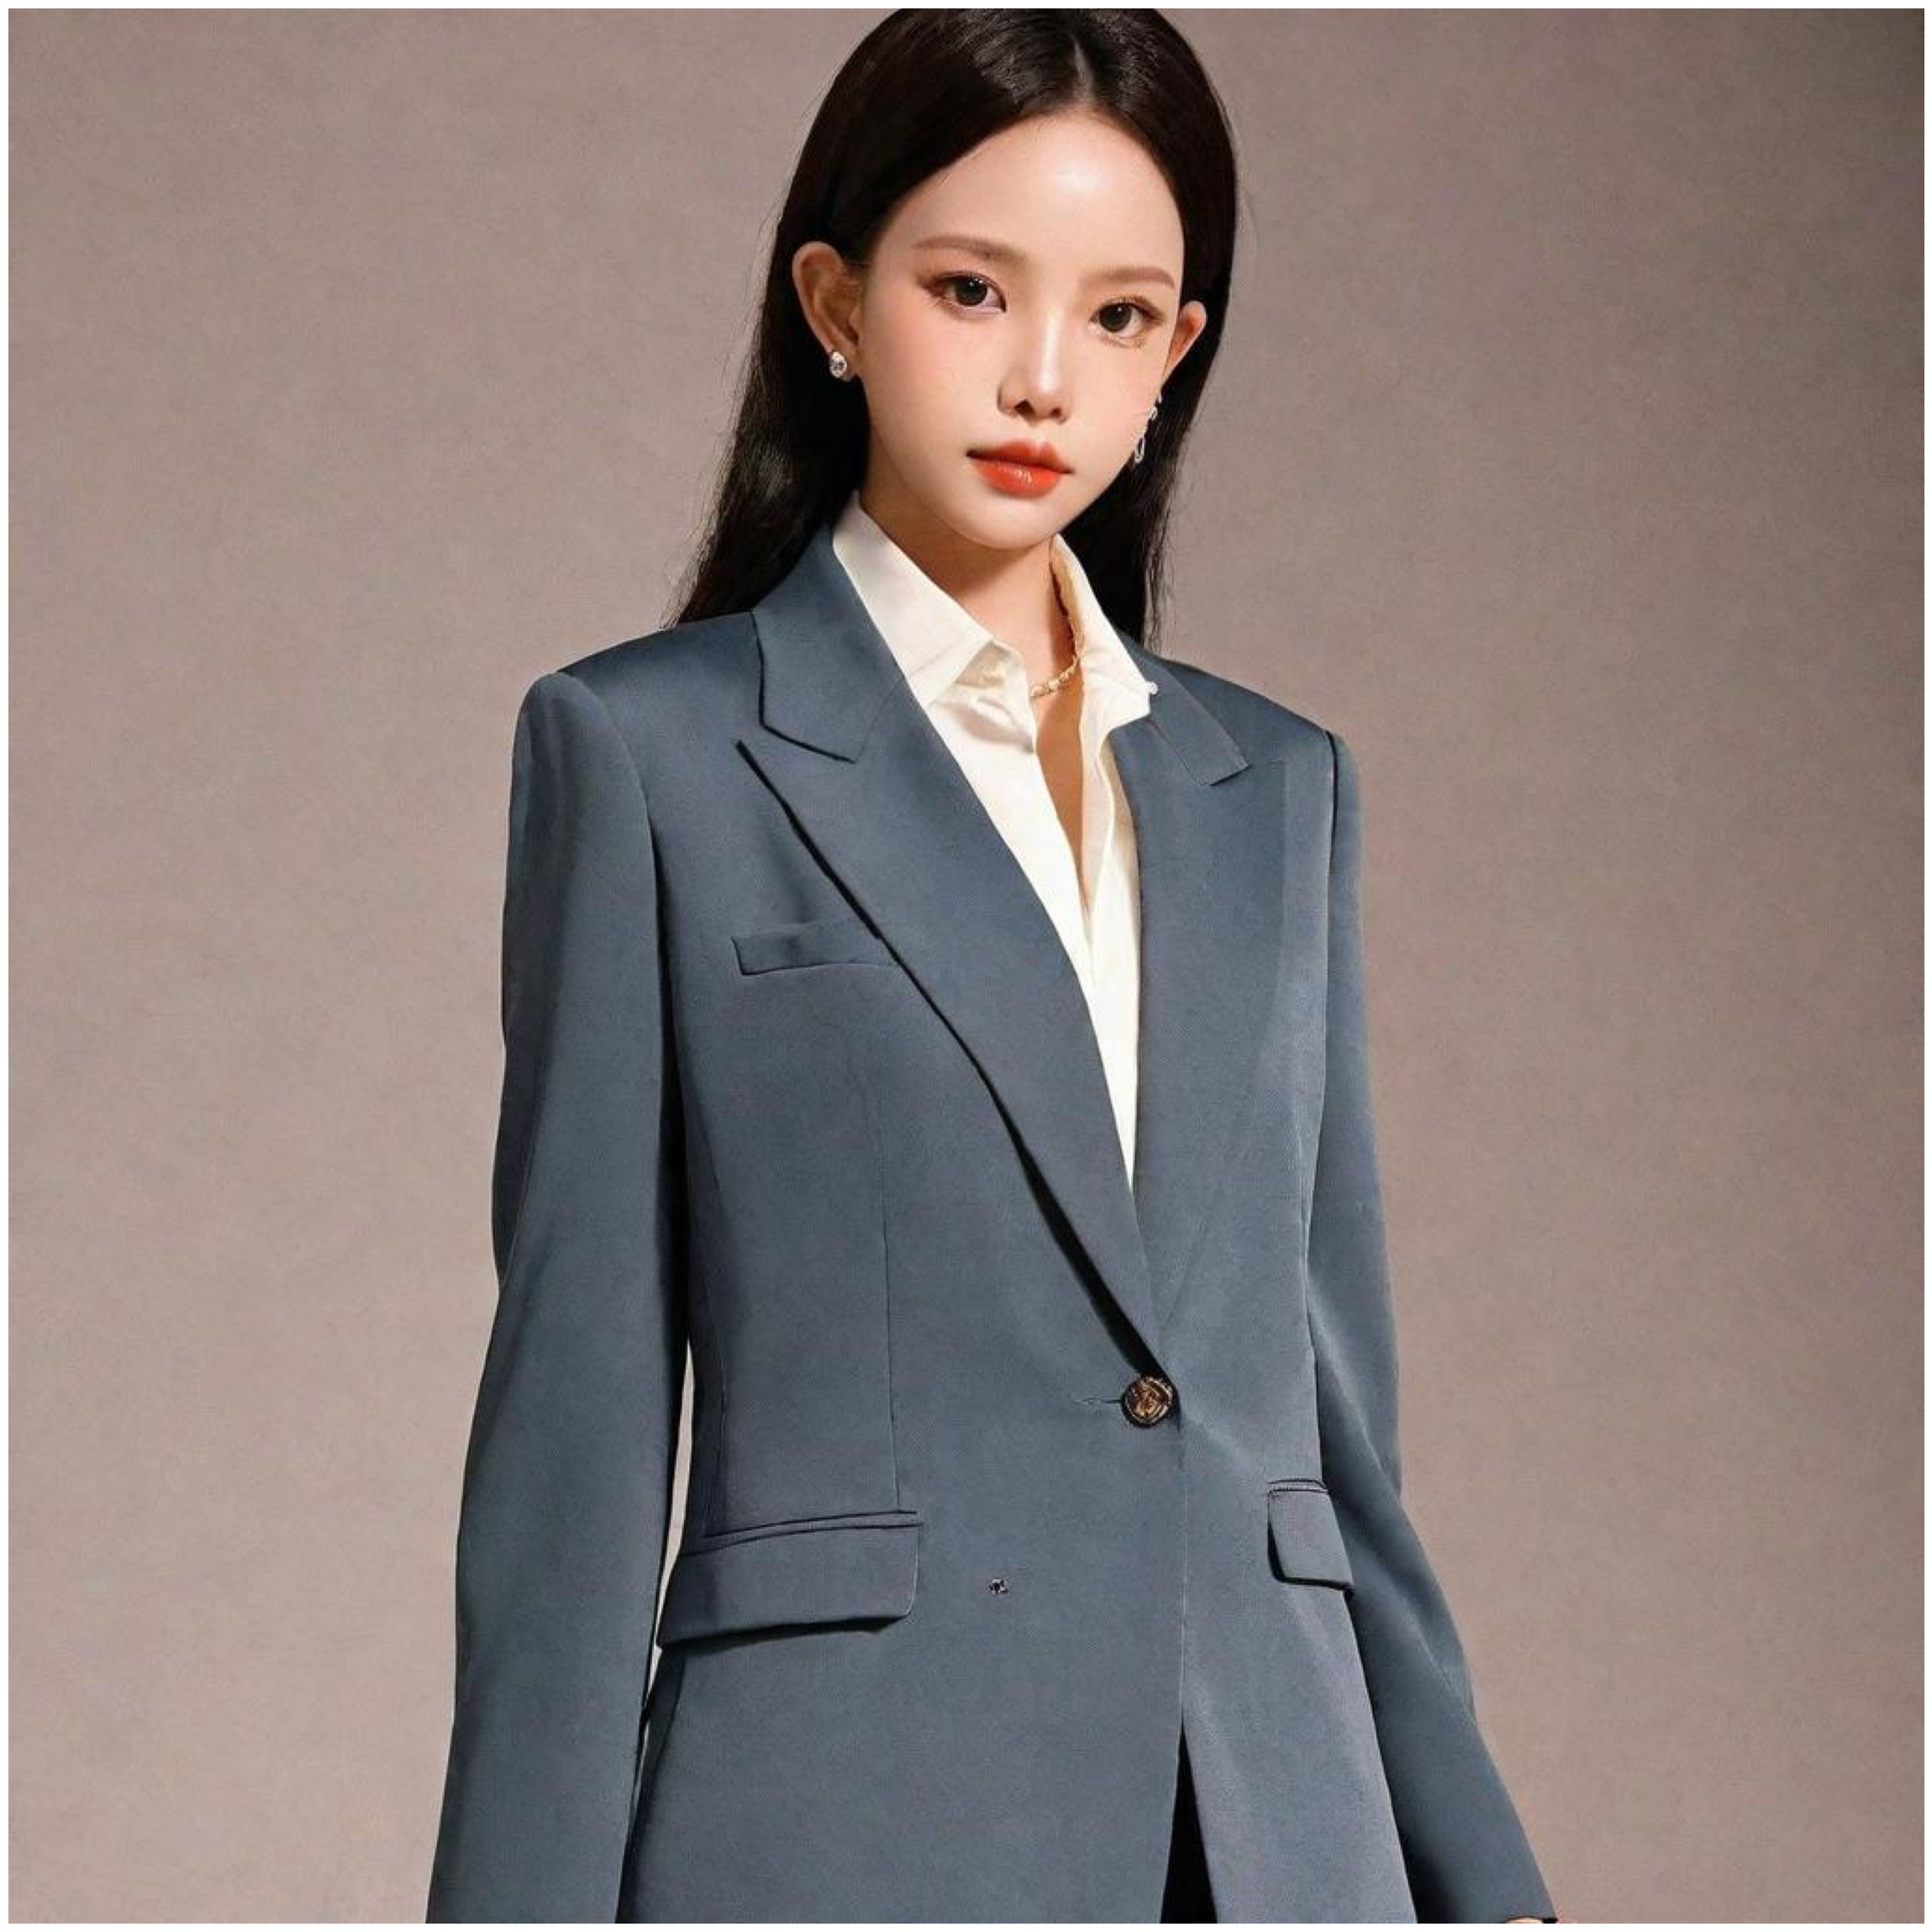

In [24]:
input_id_images = ["inputImage1.png", "inputImage2.png"]
prompt = "A luxurious and sophisticated look: Tailored blazer with sharp lines, silk blouse, wide-leg trousers or a midi skirt woman img"
data = {
    "inputs": prompt,
    "input_id_images" : input_id_images
}


# run prediction
response = predictor.predict(data={
  "inputs": prompt,
  "input_id_images" : input_id_images
  }
)
# decode images
decoded_images = [decode_base64_image(image) for image in response["images"]]

# visualize generation
display_images(decoded_images)

In [17]:
predictor.delete_model()
predictor.delete_endpoint()